In [1]:
import numpy as np
import utils
import pandas as pd
from pathlib import Path
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
np.random.seed(1337)

In [2]:
np.random.seed(1337)
synth_regular = utils.load_synthetic()
compas = utils.load_compas_alt()
RESPONSE = "two_year_recid"

In [3]:
def eo_sum(pred, prot, true):
    """
    Equation: |P(Y_pred = y_pred | Y_true = y_true, Z = 1) - P(Y_pred = y_pred | Y_true = y_true, Z = 0)|
    Assumes prot is 0/1 binary"""
    z1_y0 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 1 and y == 0]
    z0_y0 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 0 and y == 0]
    z1_y1 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 1 and y == 1]
    z0_y1 = [y_hat for y_hat, z, y in zip(
        pred, prot, true) if z == 0 and y == 1]
    return abs(sum(z1_y1)/len(z1_y1)-sum(z0_y1)/len(z0_y1)) + abs(sum(z1_y0)/len(z1_y0)-sum(z0_y0)/len(z0_y0))

In [4]:
def sigmoid(x, alpha):
    z = np.exp(-x+alpha)
    sig = 1 / (1 + z)
    return sig

In [ ]:
def confusion_matrix(true, pred):
    # Assumes numpy arrays(
    try:
        tpr = sum([1 if t == p and p == 1 else 0 for t,
                  p in zip(true, pred)])/(sum(true))
    except:
        tpr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))

    try:
        tnr = sum([1 if t == p and p == 0 else 0 for t,
                  p in zip(true, pred)])/(len(true)-sum(true))
    except:
        tnr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))
    fpr = 1-tnr
    fnr = 1-tpr
    #Old return structure. Converted to vanilla dict for json compatibility
    #return pd.DataFrame({"Predicted true": [tpr, fpr],
    #                     "Predicted false": [fnr, tnr]}, index=["Is true", "Is false"])
    return {"Predicted true": [tpr, fpr],
            "Predicted false": [fnr, tnr]}

In [113]:
from tqdm import tqdm
IMPUTATIONS = ["cca", "coldel", "mode", "mice"]
results = {imp: {"eosum":[], "acc":[], "cm": [], "tpr":[], "tnr": []} for imp in IMPUTATIONS}
for run in tqdm(range(200)):
    np.random.seed(run*13)
    compas = utils.load_compas_alt()
    for i in IMPUTATIONS:
        if i =="coldel":
            x_test = test.drop([RESPONSE, "priors_count"],axis = 1)
            clf = LogisticRegression()
            clf.fit(train.drop([RESPONSE, "priors_count"], axis = 1), train[RESPONSE])
                
            pred = clf.predict(x_test)
            y_test = test[RESPONSE]
            results[i]["eosum"].append(eo_sum(pred, x_test["gender_factor"], y_test))
            results[i]["acc"].append(accuracy_score(y_test, pred))
            cm = confusion_matrix(y_test, pred)
            results[i]["tpr"].append(cm["Predicted true"][0])
            results[i]["tnr"].append(cm["Predicted false"][1])
            continue
        
        tempeo = []
        tempacc = []
        tempcm = []
        temptpr = []
        temptnr = []
        for miss in [1,2,3]:
            #print(miss)
            train,test = compas["train"].copy(), compas["test"].copy()
            test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
            train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
            train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], miss)).astype(int)
            #print("MISSING", train["miss"].sum())
            if i =="cca":
                train = train[train["miss"]==0]
            elif i =="mode":
                miss_index = train[train["miss"]==1].index
                train["priors_count"] = train["priors_count"].mask(train.index.isin(miss_index),
                                                                        other=np.nan)
                train.fillna(train["priors_count"].mode(dropna=True)[0], inplace=True)
                #train.drop("miss", axis = 1, inplace = True)
            elif i =="mice":
                miss_index = train[train["miss"]==1].index
                train["priors_count"] = train["priors_count"].mask(train.index.isin(miss_index),
                                                                        other=np.nan)
                
                imputer = IterativeImputer(random_state=0)
                imputer.fit(train)
                train = pd.DataFrame(imputer.transform(train), columns=train.columns)
                train["priors_count"] = train["priors_count"].round()
            else:
                print("ERROR")
            train.drop("miss", axis = 1, inplace = True)
            x_test = test.drop(RESPONSE,axis = 1)
            clf = LogisticRegression()
            clf.fit(train.drop(RESPONSE, axis = 1), train[RESPONSE])
            """for s in [0,1]:
                y_test = test[test["gender_factor"]==s]
                y_test = y_test[RESPONSE]
                pred = clf.predict(x_test[x_test["gender_factor"]==s])
                print(pred.sum()-len(pred))
                print("z=1", confusion_matrix(y_test, pred))"""
                
            pred = clf.predict(x_test)
            y_test = test[RESPONSE]
            tempacc.append(accuracy_score(y_test, pred))
            tempeo.append(eo_sum(pred, x_test["gender_factor"], y_test))
            cm = confusion_matrix(y_test, pred)
            temptpr.append(cm["Predicted true"][0])
            temptnr.append(cm["Predicted false"][1])
        results[i]["eosum"].append(tempeo)
        results[i]["acc"].append(tempacc)
        results[i]["tpr"].append(temptpr)
        results[i]["tnr"].append(temptnr)

100%|██████████| 200/200 [01:08<00:00,  2.92it/s]


In [114]:
results["cca"]["eosum"]
for imp in IMPUTATIONS:
    for metr in ["eosum", "acc", "tpr", "tnr"]:
        results[imp][metr] = np.mean(results[imp][metr],axis = 0)

In [115]:
results["cca"]["eosum"][::-1]

array([1.15368609, 0.65185525, 0.10719112])

In [116]:
import matplotlib.pyplot as plt
font = {'family': 'normal',
        'weight': 'bold',
        'size': 25}

plt.rc('font', **font)

In [118]:
train.sum(axis = 1)

0       2.0
1       2.0
2       3.0
3       3.0
4       4.0
       ... 
4130    3.0
4131    3.0
4132    3.0
4133    1.0
4134    3.0
Length: 4135, dtype: float64

cca
coldel
mode
mice


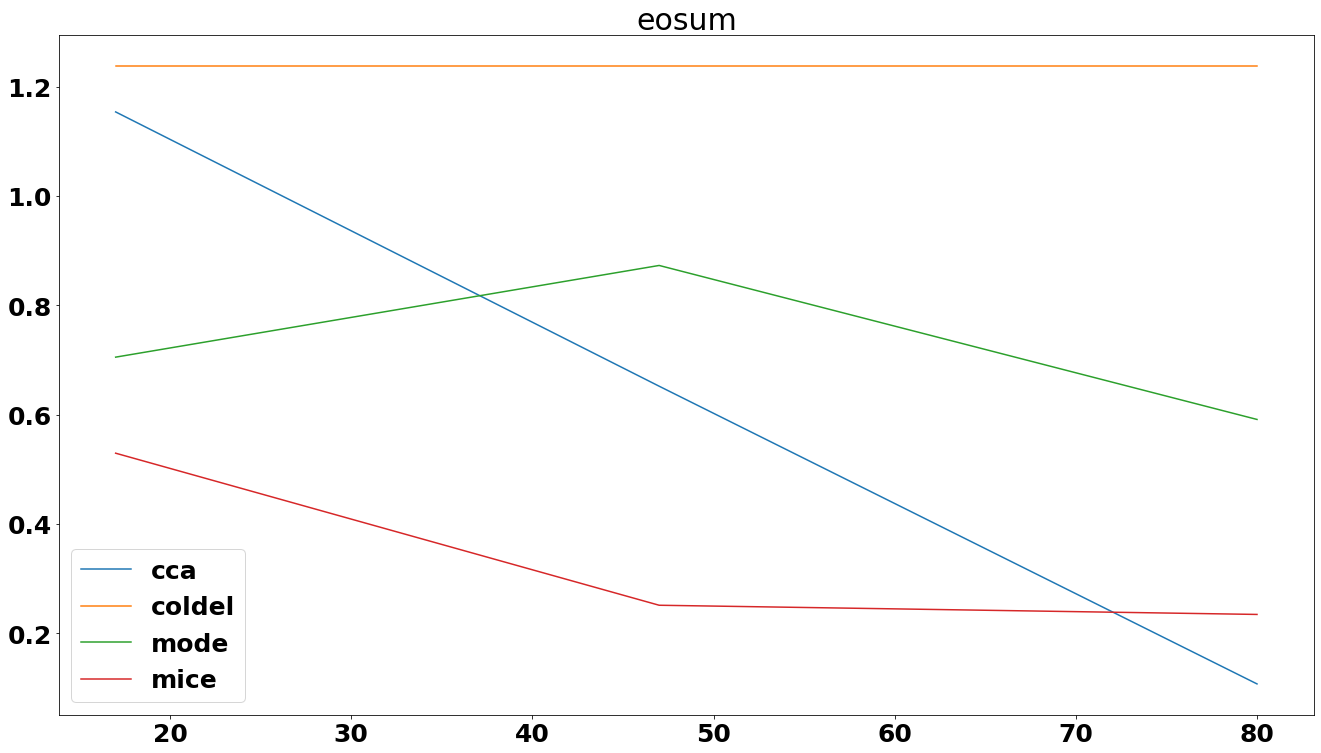

cca
coldel
mode
mice


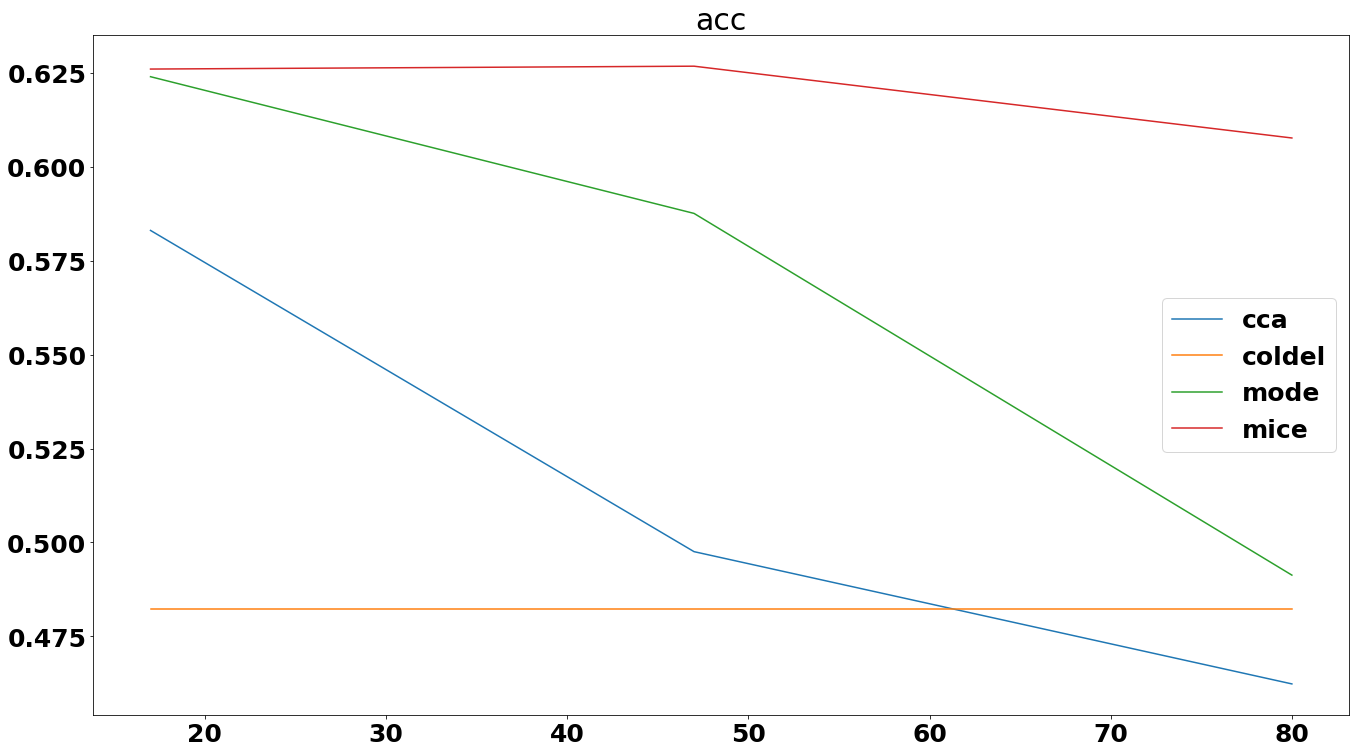

cca
coldel
mode
mice


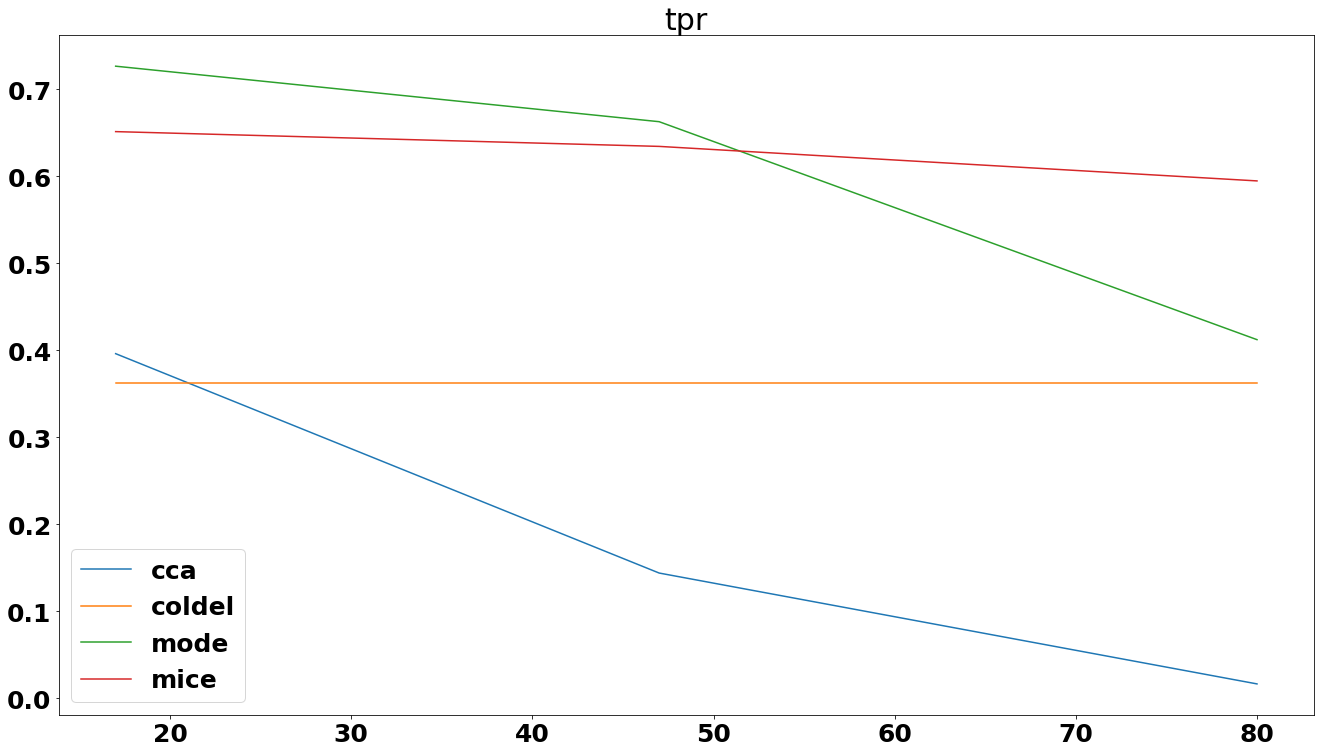

cca
coldel
mode
mice


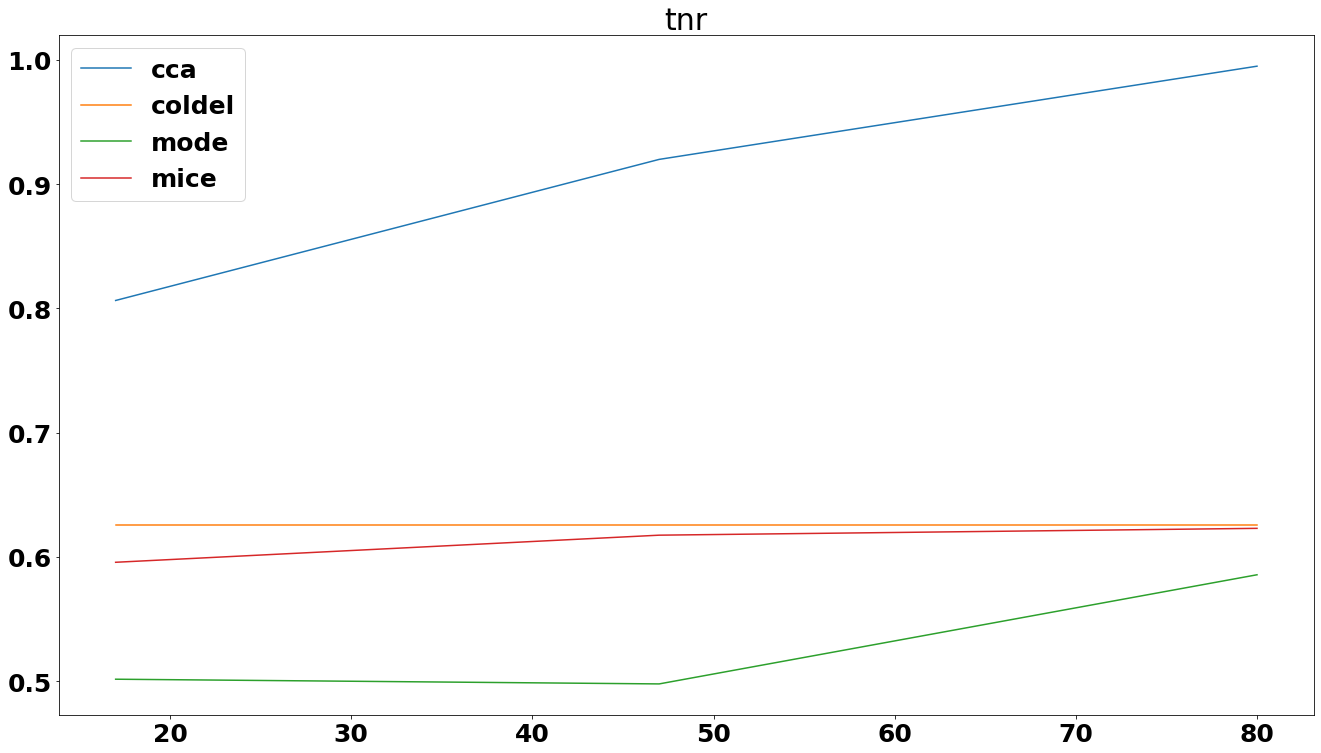

<Figure size 432x288 with 0 Axes>

In [117]:

for metr in ["eosum", "acc", "tpr", "tnr"]:
    fig = plt.gcf()
    fig.set_size_inches(22.5, 12.5)
    for imp in IMPUTATIONS:
        print(imp)
        if imp =="coldel":
            plt.plot([17,47,80], [results[imp][metr]]*3, label = imp)
        else:
            plt.plot([17,47,80], results[imp][metr][::-1], label = imp)
    plt.legend()
    plt.title(metr)
    plt.show()
    plt.clf()

In [92]:
results["cca"]["acc"]

array([0.46252332, 0.49719686, 0.58402553])

In [5]:
train,test = compas["train"].copy(), compas["test"].copy()
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)

In [7]:
train.head()

,priors_count,crime_factor,gender_factor,is_Caucasian,age_factor_Greater than 45,age_factor_Less than 25,two_year_recid
2556,1,1,0,0,1,0,1
1607,1,1,1,0,0,1,0
3027,1,0,0,0,0,0,1
2522,1,0,1,0,1,0,1
749,1,0,1,0,0,1,0


In [8]:

x_test = test.drop(RESPONSE,axis = 1)
clf = LogisticRegression()
clf.fit(train.drop(RESPONSE, axis = 1), train[RESPONSE])
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE]
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-40
z=1 {'Predicted true': [0.9153225806451613, 0.8623188405797102], 'Predicted false': [0.08467741935483875, 0.13768115942028986]}
accuracy 0.6373056994818653
-816
z=1 {'Predicted true': [0.6185567010309279, 0.3791773778920309], 'Predicted false': [0.38144329896907214, 0.6208226221079691]}
accuracy 0.6196244700181708
EO SUM:  0.7799073423019127


In [9]:
np.random.normal(0,0.1,size = len(train))

array([ 0.05973634,  0.1237859 , -0.01797131, ...,  0.03907134,
        0.0049739 , -0.02543767])

,priors_count,crime_factor,gender_factor,is_Caucasian,age_factor_Greater than 45,age_factor_Less than 25,two_year_recid
5107,6,0,1,0,0,1,0
650,6,0,1,0,0,0,1
1939,1,1,1,1,0,0,0
1989,0,0,1,0,0,0,1
415,0,1,0,1,0,0,1


In [119]:
np.random.seed(0)
compas = utils.load_compas_alt()
train, test = compas["train"], compas["test"]
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
np.around(sigmoid(train.drop("priors_count", axis = 1).sum(axis = 1), 3)).astype(int).sum()/len(train)

0.17726723095525998

In [87]:
np.random.seed(0)
compas = utils.load_compas_alt()
train, test = compas["train"].copy(), compas["test"].copy()
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int)
train = train[train["miss"]==0]
train.drop("miss", axis = 1, inplace = True)



In [49]:
np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int).sum()

1381

In [50]:
def confusion_matrix(true, pred):
    # Assumes numpy arrays(
    try:
        tpr = sum([1 if t == p and p == 1 else 0 for t,
                  p in zip(true, pred)])/(sum(true))
    except:
        tpr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))

    try:
        tnr = sum([1 if t == p and p == 0 else 0 for t,
                  p in zip(true, pred)])/(len(true)-sum(true))
    except:
        tnr = 0
        #print("true", sum(true))
        #print("pred", sum(pred))
    fpr = 1-tnr
    fnr = 1-tpr
    #Old return structure. Converted to vanilla dict for json compatibility
    #return pd.DataFrame({"Predicted true": [tpr, fpr],
    #                     "Predicted false": [fnr, tnr]}, index=["Is true", "Is false"])
    return {"Predicted true": [tpr, fpr],
            "Predicted false": [fnr, tnr]}

In [88]:

x_test = test.drop(RESPONSE,axis = 1)
clf = LogisticRegression()
clf.fit(train.drop(RESPONSE, axis = 1), train[RESPONSE])
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE].astype(int)
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-370
z=1 {'Predicted true': [0.06967213114754098, 0.01379310344827589], 'Predicted false': [0.930327868852459, 0.9862068965517241]}
accuracy 0.41131105398457585
-1648
z=1 {'Predicted true': [0.0, 0.0], 'Predicted false': [1.0, 1.0]}
accuracy 0.4733009708737864
EO SUM:  0.08346523459581684


In [16]:
np.random.seed(1337)
compas = utils.load_compas_alt()

train,test = compas["train"].copy(), compas["test"].copy()
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int)

In [17]:
miss_index = train[train["miss"]==1].index
train["priors_count"] = train["priors_count"].mask(train.index.isin(miss_index),
                                                        other=np.nan)
train.drop("miss", axis = 1, inplace = True)


In [18]:
train["priors_count"].sum()

652.0

In [19]:
imputer = IterativeImputer(random_state=0)
imputer.fit(train)
train = pd.DataFrame(imputer.transform(train), columns=train.columns)
train["priors_count"] = train["priors_count"].round()


In [20]:
train["priors_count"].sum()

2666.0

In [21]:
x_test = test.drop(RESPONSE,axis = 1)
clf = LogisticRegression()
clf.fit(train.drop(RESPONSE, axis = 1), train[RESPONSE])
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE]
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-158.0
z=1 {'Predicted true': [0.634453781512605, 0.4817518248175182], 'Predicted false': [0.365546218487395, 0.5182481751824818]}
accuracy 0.592
-862.0
z=1 {'Predicted true': [0.5908018867924528, 0.36732186732186733], 'Predicted false': [0.4091981132075472, 0.6326781326781327]}
accuracy 0.6113116726835138
EO SUM:  0.15808185221580312


In [22]:
np.random.seed(1337)
compas = utils.load_compas_alt()
train,test = compas["train"].copy(), compas["test"].copy()
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int)
miss_index = train[train["miss"]==1].index
train["priors_count"] = train["priors_count"].mask(train.index.isin(miss_index),
                                                        other=np.nan)
train.drop("miss", axis = 1, inplace = True)
train.fillna(train["priors_count"].mode(dropna=True)[0], inplace=True)
x_test = test.drop(RESPONSE,axis = 1)
clf = LogisticRegression()
clf.fit(train.drop(RESPONSE, axis = 1), train[RESPONSE])
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE]
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-107
z=1 {'Predicted true': [0.6890756302521008, 0.7591240875912408], 'Predicted false': [0.31092436974789917, 0.24087591240875914]}
accuracy 0.5253333333333333
-1053
z=1 {'Predicted true': [0.3490566037735849, 0.3845208845208845], 'Predicted false': [0.6509433962264151, 0.6154791154791155]}
accuracy 0.4795427196149218
EO SUM:  0.7146222295488722


In [23]:
from fair_logistic_reg import FairLogisticRegression

In [24]:
np.random.seed(1337)
compas = utils.load_compas_alt()
train,test = compas["train"], compas["test"]
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int)

In [25]:
data = train.copy()
flr = FairLogisticRegression(fairness_metric = "eo_sum",lam = 0.995)
obs_data = data.dropna()
x = obs_data.drop("priors_count", axis = 1)
y = obs_data["priors_count"]
z = obs_data["gender_factor"]
flr.fit(x,y,z, epochs=100)

x_miss = data[data["priors_count"].isnull()].drop("priors_count",axis = 1)
y_hat = flr.predict(x_miss)
data.loc[data["priors_count"].isnull(),"priors_count"] = y_hat 

In [26]:
x_test = test.drop(RESPONSE,axis = 1)
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE]
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-107
z=1 {'Predicted true': [0.6890756302521008, 0.7591240875912408], 'Predicted false': [0.31092436974789917, 0.24087591240875914]}
accuracy 0.5253333333333333
-1053
z=1 {'Predicted true': [0.3490566037735849, 0.3845208845208845], 'Predicted false': [0.6509433962264151, 0.6154791154791155]}
accuracy 0.4795427196149218
EO SUM:  0.7146222295488722


In [27]:
np.random.seed(1337)
compas = utils.load_compas_alt()
train,test = compas["train"], compas["test"]
test["priors_count"] = test["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["priors_count"] = train["priors_count"].apply(lambda x: 1 if x>0 else 0)
train["miss"] =np.around(sigmoid(train["crime_factor"] +train["gender_factor"] + train["is_Caucasian"] + train["age_factor_Greater than 45"] + train["age_factor_Less than 25"] + train["two_year_recid"], 1)).astype(int)
data = train.copy()
flr = FairLogisticRegression(fairness_metric = "eo_sum",lam = 0.0)
obs_data = data.dropna()
x = obs_data.drop("priors_count", axis = 1)
y = obs_data["priors_count"]
z = obs_data["gender_factor"]
flr.fit(x,y,z, epochs=100)

x_miss = data[data["priors_count"].isnull()].drop("priors_count",axis = 1)
y_hat = flr.predict(x_miss)
data.loc[data["priors_count"].isnull(),"priors_count"] = y_hat 

In [28]:
x_test = test.drop(RESPONSE,axis = 1)
for s in [0,1]:
    y_test = test[test["gender_factor"]==s]
    y_test = y_test[RESPONSE]
    pred = clf.predict(x_test[x_test["gender_factor"]==s])
    print(pred.sum()-len(pred))
    print("z=1", confusion_matrix(y_test, pred))
    print("accuracy", accuracy_score(y_test, pred))
pred = clf.predict(x_test)
y_test = test[RESPONSE]
print("EO SUM: ", eo_sum(pred, x_test["gender_factor"], y_test))

-107
z=1 {'Predicted true': [0.6890756302521008, 0.7591240875912408], 'Predicted false': [0.31092436974789917, 0.24087591240875914]}
accuracy 0.5253333333333333
-1053
z=1 {'Predicted true': [0.3490566037735849, 0.3845208845208845], 'Predicted false': [0.6509433962264151, 0.6154791154791155]}
accuracy 0.4795427196149218
EO SUM:  0.7146222295488722
